### Preparing Data

In [ ]:
# Install packages
import torch
from torchtext import data
from torchtext import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import spacy
import time
import matplotlib.pyplot as plt

#Load English language
nlp = spacy.load('en')

In [2]:
TEXT = data.Field(tokenize = 'spacy', batch_first = True)
LABEL = data.LabelField(dtype = torch.float)
# Load data from torchtext (identical to what we have in Kaggle)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split()

# Initiate class instances with tokenizers


In [3]:
# Select only the most important 30000 words
MAX_VOCAB_SIZE = 30_000

# Build vocabularies
TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 # Load pretrained embeddings
                 vectors = "glove.6B.100d", 
                 # Set unknown vectors
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [4]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create PyTorch iterators to use in training/evaluation/testing
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

### Build Model

We visualize our words in 2 dimensions, each word along one axis and the elements of the word embedding that corresponds to this word aross the other dimension.

In the model, we will have different sizes of filters, heights of 1, 2, 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different bi-grams, tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews.

The idea behind max-pooling is that the maximum value is the "most important" feature for determining the sentiment of the review, which corresponds to the "most important" n-gram within the review that is identified through backprop.

After getting 400 different n-grams, we concatenate them together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 500 n-grams and making a final decision. 

In [5]:
class CNN_Text(nn.Module):
    ''' Define network architecture and forward path. '''
    def __init__(self, vocab_size, 
                 vector_size, n_filters, 
                 filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        # Create word embeddings from the input words     
        self.embedding = nn.Embedding(vocab_size, vector_size, 
                                      padding_idx = pad_idx)
        
        # Specify convolutions with filters of different sizes (fs)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, vector_size)) 
                                    for fs in filter_sizes])
        
        # Add a fully connected layer for final predicitons
        self.linear = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        # Drop some of the nodes to increase robustness in training
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, text):
        '''Forward path of the network.'''       
        # Get word embeddings and formt them for convolutions
        embedded = self.embedding(text).unsqueeze(1)
        
        # Perform convolutions and apply activation functions
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        # Pooling layer to reduce dimensionality    
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        # Dropout layer
        cat = self.dropout(torch.cat(pooled, dim = 1))
        return self.linear(cat)

## Initialize Pre-Trained Model

In [6]:
# Vocabulary size
INPUT_DIM = len(TEXT.vocab)

# Vector size (lower-dimensional repr. of each word)
EMBEDDING_DIM = 100

# Number of filters
N_FILTERS = 100

# N-grams that we want to analuze using filters
FILTER_SIZES = [1, 2, 3, 4, 5]

# Output of the linear layer (prob of a negative review)
OUTPUT_DIM = 1

# Proportion of units to drop
DROPOUT = 0.5

In [7]:
# Zero the initial weights of the UNKnown and padding tokens.
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

# The string token used as padding. Default: “<pad>”.
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

# Initialize model and load pre-trained embeddings
model = CNN_Text(INPUT_DIM, EMBEDDING_DIM, 
            N_FILTERS, FILTER_SIZES, 
            OUTPUT_DIM, DROPOUT, PAD_IDX)

model.embedding.weight.data.copy_(TEXT.vocab.vectors)



model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model = model.to(device)

## Train & Evaluate Model

In [8]:
# Helper functions
def accuracy(preds, y):
    """ Return accuracy per batch. """
    correct = (torch.round(torch.sigmoid(preds)) == y).float() 
    return correct.sum() / len(correct)

def epoch_time(start_time, end_time):
    '''Track training time. '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
def train(model, iterator, optimizer, criterion):
    '''Train the model with specified data, optimizer, and loss function. '''
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        # Reset the gradient to not use them in multiple passes 
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = accuracy(predictions, batch.label)
        
        # Backprop
        loss.backward()
        
        # Optimize the weights
        optimizer.step()
        
        # Record accuracy and loss
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    '''Evaluate model performance. '''
    epoch_loss = 0
    epoch_acc = 0
    
    # Turm off dropout while evaluating
    model.eval()
    
    # No need to backprop in eval
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [10]:
# Network optimizer
optimizer = optim.Adam(model.parameters())

# Loss function
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [11]:
# Training loop
N_EPOCHS = 10

best_valid_loss = float('inf')
val_loss = []
val_acc = []
tr_loss = []
tr_acc = []

for epoch in range(N_EPOCHS):
    
    # Calculate training time
    start_time = time.time()
    
    # Get epoch losses and accuracies 
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # Save training metrics
    val_loss.append(valid_loss)
    val_acc.append(valid_acc)
    tr_loss.append(train_loss)
    tr_acc.append(train_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(4), 'CNN-model.pt')
    
    print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch:  1 | Epoch Time: 19m 50s
	Train Loss: 0.649 | Train Acc: 62.22%
	 Val. Loss: 0.498 |  Val. Acc: 77.97%
Epoch:  2 | Epoch Time: 19m 55s
	Train Loss: 0.434 | Train Acc: 80.01%
	 Val. Loss: 0.359 |  Val. Acc: 85.00%
Epoch:  3 | Epoch Time: 19m 48s
	Train Loss: 0.311 | Train Acc: 86.98%
	 Val. Loss: 0.317 |  Val. Acc: 87.00%
Epoch:  4 | Epoch Time: 19m 38s
	Train Loss: 0.226 | Train Acc: 90.80%
	 Val. Loss: 0.312 |  Val. Acc: 87.44%
Epoch:  5 | Epoch Time: 19m 56s
	Train Loss: 0.158 | Train Acc: 93.89%
	 Val. Loss: 0.329 |  Val. Acc: 87.24%
Epoch:  6 | Epoch Time: 20m 2s
	Train Loss: 0.115 | Train Acc: 95.96%
	 Val. Loss: 0.343 |  Val. Acc: 87.28%
Epoch:  7 | Epoch Time: 19m 46s
	Train Loss: 0.077 | Train Acc: 97.45%
	 Val. Loss: 0.369 |  Val. Acc: 87.17%
Epoch:  8 | Epoch Time: 19m 40s
	Train Loss: 0.054 | Train Acc: 98.24%
	 Val. Loss: 0.391 |  Val. Acc: 87.30%
Epoch:  9 | Epoch Time: 19m 31s
	Train Loss: 0.038 | Train Acc: 98.84%
	 Val. Loss: 0.427 |  Val. Acc: 87.42%
Epoch: 10 |

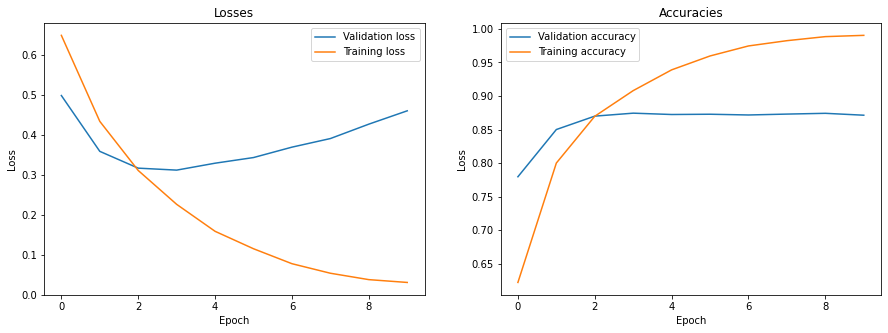

In [12]:
# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(val_loss, label='Validation loss')
ax[0].plot(tr_loss, label='Training loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_acc, label='Validation accuracy')
ax[1].plot(tr_acc, label='Training accuracy')
ax[1].set_title('Accuracies')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Evaluate model on test data
model.load_state_dict(torch.load('CNN-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.340 | Test Acc: 85.26%


### Check performance with arbitrary sentences

In [14]:
def sentiment(model, sentence, min_len = 5):
    '''Predict user-defined review sentiment.'''
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    # Map words to word embeddings
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    # Get predicitons
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

In [15]:
reviews = ['This is the best movie I have ever watched!', 
           'This is an okay movie', 
           'This was a waste of time! I hated this movie.']
scores = [sentiment(model, review) for review in reviews]
scores

[0.011825579218566418, 0.5712445974349976, 0.9814573526382446]

In [16]:
tricky_reviews = ['This is not the best movie I have ever watched!', 
           'Some would say it is an okay movie, but I found it terrific.', 
           'This was a waste of time! I did not like this movie.']
scores = [sentiment(model, review) for review in tricky_reviews]
scores

[0.04034795984625816, 0.42758339643478394, 0.9908714890480042]